# Title I Allocations w/ DP ACS

## Algorithm

### Data
Need state per-pupil expenditure (SPPE) from the NCES. Most recent I can find in <5min is the [FY '18 data](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2020308).

Had to use an online tool to convert Table 2 of [this report](https://nces.ed.gov/pubs2020/2020308.pdf).

In [100]:
def get_sppe(path):
    states = { 'Alabama': 'AL', 'Alaska': 'AK', 'American Samoa': 'AS', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Guam': 'GU', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Northern Mariana Islands':'MP', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Puerto Rico': 'PR', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virgin Islands': 'VI', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY' }
    states = pd.DataFrame(states.items(), columns=["state", "abbrv"])
    
    # quirk of original data file - need to change DC's name for join
    states[states.state == "District of Columbia"] = "District Of Columbia Public Schools"

    sppe = pd.read_excel(path, header=2).rename(columns={"Unnamed: 0": "state"})[["state", "ppe"]]

    return sppe.merge(states, on="state", how="right")

sppe = get_sppe("../data/sppe18.xlsx")
sppe.head()

,state,ppe,abbrv
0,Alabama,9697,AL
1,Alaska,17726,AK
2,American Samoa,NaN,AS
3,Arizona,8296,AZ
4,Arkansas,10072,AR


Also need a dict matching district IDs to district names to states. Simplest to use [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) ground-truth.

In [123]:
saipe = pd.read_excel("../data/saipe19.xls", header=2).set_index("District ID")
saipe.head()

,State Postal Code,State FIPS Code,Name,Estimated Total Population,Estimated Population 5-17,Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder
District ID,,,,,,
190,AL,1,Alabaster City School District,34669,6710,649
5,AL,1,Albertville City School District,22051,4131,957
30,AL,1,Alexander City City School District,16920,2575,703
60,AL,1,Andalusia City School District,8842,1465,406
90,AL,1,Anniston City School District,22043,3065,1057


### Code

In [124]:
import pandas as pd
from typing import Tuple

class Mechanism:
    def __init__(self, epsilon, delta):
        self.epsilon = epsilon
        self.delta = delta
        
    def poverty_estimates(self) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Returns dataframe for children in poverty, children total, and total population indexed by district ID.
        """
        raise NotImplementedError
        
class GroundTruth(Mechanism):
    """
    example mech that just returns the ground truth SAIPE estimates
    """
    def __init__(self, saipe):
        self.saipe = saipe
        
    def poverty_estimates(self):
        return (self.saipe[key] for key in ["Estimated Total Population", "Estimated Population 5-17", "Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"])

In [238]:
from math import floor, ceil

def weighting(eligible, pop):
    """
    Gradated weighting algorithm given in [Sonnenberg](https://nces.ed.gov/surveys/annualreports/pdf/titlei20160111.pdf).
    
    Returns weighted eligibility counts.
    """
    
    # calculate weighted count based on counts
    wec_counts = 0
    for r, w in {(1, 691): 1.0, (692, 2262): 1.5, (2263,7851): 2.0, (7852, 35514): 2.5, (35514, None): 3.0}.items():
        if r[1] is not None and eligible > r[1]: 
            wec_counts += (r[1] - r[0] + 1) * w
        elif eligible >= r[0]: 
            wec_counts += (eligible - r[0] + 1) * w
    
    # calculate weighted count based on proportions
    wec_props = 0
    for r, w in {(0, 0.1558): 1.0, (0.1558, 0.2211): 1.75, (0.2211,0.3016): 2.5, (0.3016, 0.3824): 3.25, (0.3824, None): 4.0}.items():
        upper = floor(r[1]*pop) if r[1] is not None else None
        lower = ceil(r[0]*pop)
        
        if upper is not None and eligible > upper: 
            wec_props += (upper - lower) * w
        elif eligible >= lower: 
            wec_props += (eligible - lower) * w
    
    # take the higher weighted eligibility count
    return max(wec_counts, wec_props)
    
weighting(1559, 10000)

1993.0

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


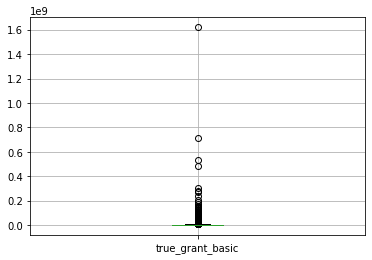

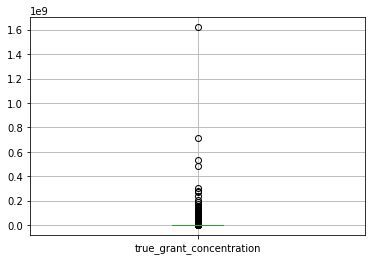

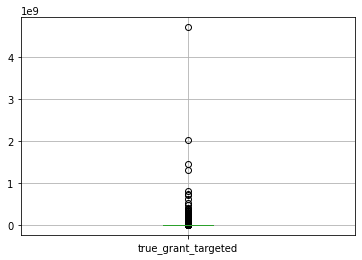

In [265]:
import numpy as np

def funding(saipe, mechanism, sppe, weighting, adj_sppe_bounds=[0.32, 0.48], adj_sppe_bounds_efig=[0.34, 0.46], congress_cap=0.4, *mech_args, verbose=True, **mech_kwargs):
    """
    congress_cap - proportion of a student's edu congress agrees to fund
    
    Returns augmented SAIPE dataframe with randomized estimates and true/randomized grant amounts.
    """
    grants = saipe.rename(columns={
        "Estimated Total Population": "true_pop_total",
        "Estimated Population 5-17": "true_children_total",
        "Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder": "true_children_poverty"
    })
    pop_total, children_total, children_poverty = mechanism.poverty_estimates(*mech_args, **mech_kwargs)
    grants["est_pop_total"] = pop_total
    grants["est_children_total"] = children_total
    grants["est_children_poverty"] = children_poverty

    # BIG ASSUMPTION, TODO: revisit later
    grants["true_children_eligible"] = grants.true_children_poverty
    grants["est_children_eligible"] = grants.est_children_poverty
    
    # join in SPPE
    grants = grants.merge(sppe, left_on="State Postal Code", right_on="abbrv").drop(columns=['abbrv', 'state']).rename(columns={'ppe': 'sppe'})
    if verbose: print("[WARN] Dropping districts with missing SPPE data:", grants[grants.sppe.isna()]['Name'].values)
    grants = grants.dropna(subset=["sppe"])
    grants.sppe = grants.sppe.astype(float)
    
    # calculate grant amounts for true/randomized values
    for prefix in ("true", "est"):        
        # calculate adjusted SPPE
        avg_sppe = np.mean(grants.sppe)
        adj_sppe = grants.sppe * congress_cap
        adj_sppe_trunc = adj_sppe.clip(*np.array(adj_sppe_bounds)*avg_sppe)
        adj_sppe_efig = adj_sppe.clip(*np.array(adj_sppe_bounds_efig)*avg_sppe)
#         # double check calc
#         print(np.array(adj_sppe_bounds)*avg_sppe)
#         print(min(adj_sppe_trunc), max(adj_sppe_trunc))
            
        ## BASIC GRANTS
        # authorization calculation
        grants[f"{prefix}_grant_basic"] = grants[f"{prefix}_children_eligible"] * adj_sppe_trunc
        # For basic grants, LEA must have >10 eligible children
        eligible = grants[f"{prefix}_children_eligible"] >= 10
#         print(sum(~eligible)/eligible.shape[0])
        grants.loc[~eligible, f"{prefix}_grant_basic"] = 0.0
        
        ## CONCENTRATION GRANTS
        # For concentration grants, LEAs must meet basic eligibility AND have either
        # a) >6500 eligible
        # b) 15% of pop. is eligible
        grants[f"{prefix}_grant_concentration"] = grants[f"{prefix}_grant_basic"]
        count_eligible = grants[f"{prefix}_children_eligible"] >= 6500
        prop_eligible = (grants[f"{prefix}_children_eligible"] / grants[f"{prefix}_children_total"]) >= 0.15
        eligible = count_eligible | prop_eligible
#         print(sum(~eligible)/eligible.shape[0])
        grants.loc[~eligible, f"{prefix}_grant_concentration"] = 0.0
        
        ## TARGETED GRANTS
        # weighted by an exogenous step function - see documentation
        weighted_eligible = grants[[f"{prefix}_children_eligible", f"{prefix}_children_total"]].apply(
            lambda x: weighting(x[0], x[1])
        , axis=1)
        grants[f"{prefix}_grant_targeted"] = weighted_eligible * adj_sppe_trunc
        
        # for targeted grants, LEAs must meet basic eligibility AND have >5% eligible
        count_eligible = grants[f"{prefix}_children_eligible"] >= 10
        prop_eligible = (grants[f"{prefix}_children_eligible"] / grants[f"{prefix}_children_total"]) >= 0.05
        eligible = count_eligible & prop_eligible
        grants.loc[~eligible, f"{prefix}_grant_targeted"] = 0.0
        
        ## EFIG
        # TODO
        
    
    # TODO - calculate *allocation* amounts
    return grants


# Test with ground truth mechanism
grants = funding(saipe, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx"), weighting)
grants.boxplot('true_grant_basic')
plt.show()
grants.boxplot('true_grant_concentration')
plt.show()
grants.boxplot('true_grant_targeted')
plt.show()

## Laplace
### Data
From [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) release.

### Mechanism

In [253]:
from diffprivlib.mechanisms.laplace import Laplace as LaplaceMech, LaplaceTruncated

"""
Following Abowd & Schmutte (2019), return \hat{E}_l = E_l + e_l, where e_l \sim Laplace(1/\epsilon). 

Recall that the sensitivity of the counts here is simply 1.
"""

class Laplace(Mechanism):
    def __init__(self, saipe, *args, pos_trunc=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.saipe = saipe
        
        self.mechanism = \
            LaplaceTruncated(epsilon=self.epsilon, delta=self.delta, sensitivity=1.0, lower=0.0) if pos_trunc \
            else LaplaceMech(epsilon=self.epsilon, delta=self.delta, sensitivity=1.0)
        
    def poverty_estimates(self) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        
        pop_total = saipe["Estimated Total Population"].apply(self.mechanism.randomise)
        children_total = saipe["Estimated Population 5-17"].apply(self.mechanism.randomise)
        children_poverty = saipe["Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"].apply(self.mechanism.randomise)
        
        return pop_total, children_total, children_poverty
        
Laplace(saipe, 0.1, 0).poverty_estimates()

(District ID
 190     3.467342e+04
 5       2.204129e+04
 30      1.692139e+04
 60      8.839431e+03
 90      2.203456e+04
             ...     
 6240    7.128489e+03
 5820    6.600198e+02
 4830    5.468558e+03
 6090    1.482525e+03
 30      3.193698e+06
 Name: Estimated Total Population, Length: 13184, dtype: float64,
 District ID
 190       6709.002770
 5         4134.198189
 30        2552.834732
 60        1469.151271
 90        3062.912105
             ...      
 6240      1298.393395
 5820        99.512903
 4830       817.663728
 6090       245.715072
 30      455240.582161
 Name: Estimated Population 5-17, Length: 13184, dtype: float64,
 District ID
 190        662.449752
 5          955.756806
 30         710.940053
 60         399.365081
 90        1062.022556
             ...      
 6240       147.398953
 5820        17.289530
 4830       100.830679
 6090        15.060072
 30      248583.248013
 Name: Estimated number of relevant children 5 to 17 years old in poverty who are 

### Testing

In [259]:
grants = funding(saipe, Laplace(saipe, 5, 0), get_sppe("../data/sppe18.xlsx"), weighting)
grants.describe()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


,State FIPS Code,true_pop_total,true_children_total,true_children_poverty,est_pop_total,est_children_total,est_children_poverty,est_children_eligible,children_eligible,true_children_eligible,sppe,true_grant_basic,true_grant_concentration,true_grant_targeted,est_grant_basic,est_grant_concentration,est_grant_targeted
count,13182.000000,1.318200e+04,1.318200e+04,13182.000000,1.318200e+04,1.318200e+04,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04,1.318200e+04
mean,29.561751,2.651938e+04,4.049290e+03,625.253224,2.651938e+04,4.049290e+03,625.252319,625.252319,625.253224,625.253224,13027.845092,3.026463e+06,2.231939e+06,5.062192e+06,3.026331e+06,2.232184e+06,5.062020e+06
std,14.644764,1.155746e+05,1.728792e+04,3467.140325,1.155746e+05,1.728793e+04,3467.140698,3467.140698,3467.140325,3467.140325,3667.794832,1.912444e+07,1.908713e+07,5.239813e+07,1.912446e+07,1.908716e+07,5.239812e+07
min,1.000000,0.000000e+00,0.000000e+00,0.000000,-2.299442e-01,-2.847493e-01,-0.376212,-0.376212,0.000000,0.000000,7525.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,18.000000,2.802000e+03,4.260000e+02,52.000000,2.801901e+03,4.260598e+02,52.090541,52.090541,52.000000,52.000000,10157.000000,2.617935e+05,0.000000e+00,1.924048e+05,2.606675e+05,0.000000e+00,1.928942e+05
50%,30.000000,7.911000e+03,1.186000e+03,147.000000,7.910774e+03,1.186007e+03,147.114443,147.114443,147.000000,147.000000,12159.000000,7.504039e+05,0.000000e+00,7.283281e+05,7.499323e+05,0.000000e+00,7.276738e+05
75%,40.000000,2.101825e+04,3.222000e+03,411.000000,2.101803e+04,3.221940e+03,411.227213,411.227213,411.000000,411.000000,15780.000000,2.076117e+06,9.130432e+05,2.294255e+06,2.077600e+06,9.143967e+05,2.294270e+06
max,56.000000,8.336817e+06,1.193045e+06,259012.000000,8.336817e+06,1.193045e+06,259011.806086,259011.806086,259012.000000,259012.000000,22845.000000,1.619697e+09,1.619697e+09,4.714287e+09,1.619696e+09,1.619696e+09,4.714284e+09


In [283]:
# rmse basic
eps = np.linspace(0.1, 10, 100)
allocations = []
for e in eps:
    print(e, end=" ")
    allocations.append(funding(saipe, Laplace(saipe, e, 0), get_sppe("../data/sppe18.xlsx"), weighting, verbose=False))

0.1 0.2 0.30000000000000004 0.4 0.5 0.6 0.7000000000000001 0.8 0.9 1.0 1.1 1.2000000000000002 1.3000000000000003 1.4000000000000001 1.5000000000000002 1.6 1.7000000000000002 1.8000000000000003 1.9000000000000001 2.0 2.1 2.2 2.3000000000000003 2.4000000000000004 2.5000000000000004 2.6 2.7 2.8000000000000003 2.9000000000000004 3.0000000000000004 3.1 3.2 3.3000000000000003 3.4000000000000004 3.5000000000000004 3.6 3.7 3.8000000000000003 3.9000000000000004 4.0 4.1 4.2 4.3 4.3999999999999995 4.5 4.6 4.7 4.8 4.9 5.0 5.1 5.2 5.3 5.4 5.5 5.6 5.7 5.8 5.9 6.0 6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.0 7.1 7.2 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8.0 8.1 8.2 8.3 8.4 8.5 8.6 8.7 8.8 8.9 9.0 9.1 9.2 9.3 9.4 9.5 9.6 9.700000000000001 9.8 9.9 10.0 

RMSE at eps=2.5: 4001.5812184365477
RMSE at eps=2.5: 4307.852586561397


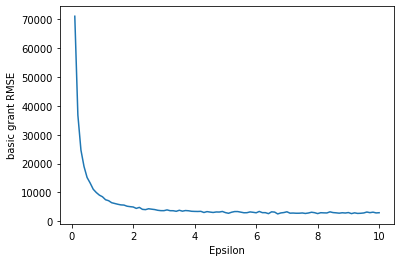

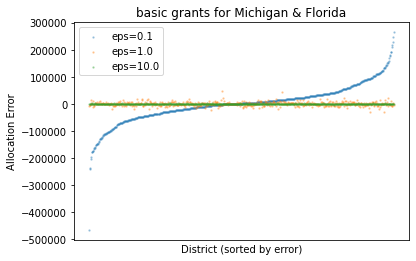

RMSE at eps=2.5: 30288.859102284026
RMSE at eps=2.5: 61940.03826250608


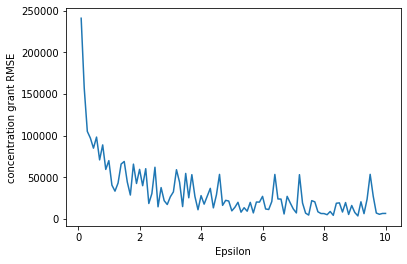

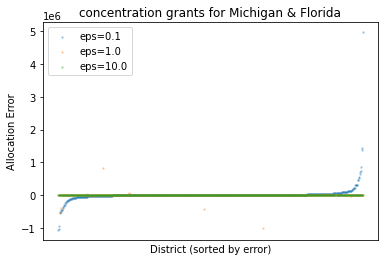

RMSE at eps=2.5: 19175.74060586576
RMSE at eps=2.5: 21048.14318244785


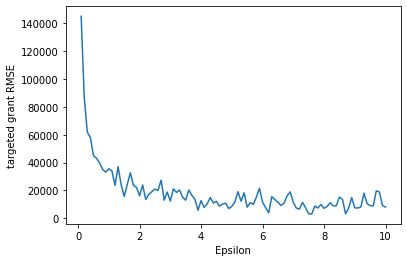

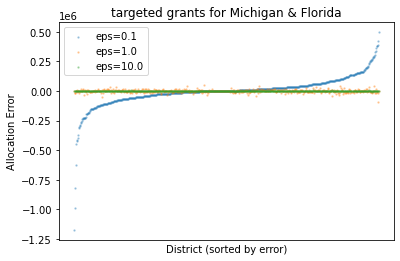

In [347]:
for grant_type in ("basic", "concentration", "targeted"):
    mse = []
    for alloc, e in zip(allocations, eps):
        error = alloc[f"true_grant_{grant_type}"]-alloc[f"est_grant_{grant_type}"]
        mse.append(np.sqrt(sum(error**2)/alloc.shape[0]))
        if (e > 2.4 and e < 2.6):
            print("RMSE at eps=2.5:", np.sqrt(sum(error**2)/alloc.shape[0]))

    plt.plot(eps, mse)
    plt.xlabel("Epsilon")
    plt.ylabel(f"{grant_type} grant RMSE")
    plt.show()
    
    for i in [0, 9, -1]:
        e = eps[i]
        alloc = allocations[i]
        alloc = alloc[(alloc["State Postal Code"] == "MI") | (alloc["State Postal Code"] == "FL")].sort_values(f"est_grant_{grant_type}")
        alloc['err'] = alloc[f"true_grant_{grant_type}"]-alloc[f"est_grant_{grant_type}"]
        alloc = alloc.sort_values('err')
        plt.scatter(alloc.index.astype('str'), alloc.err, s=2, alpha=0.3, label=f"eps={e}")
    ax = plt.gca()
    ax.legend()
    ax.axes.xaxis.set_ticks([])
    plt.xlabel("District (sorted by error)")
    plt.ylabel("Allocation Error")
    plt.title(f"{grant_type} grants for Michigan & Florida")
    plt.show()